In [33]:
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"


Number of GPUs : 1
Tensorflow GPU : True


Two JSON files (CLEVR_train_questions.json and CLEVR_val_questions.json) were loaded, containing questions and answers related to images.
Only 500 data points (questions and answers) from each JSON file was chosen to create training and validation datasets.

In [8]:
#train_dataframe and val_dataframe stores the path to the images and respective questions and answers
lenghtData = 500

trainList=[]
with open('/home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/questions/CLEVR_train_questions.json') as f:
    data = json.load(f)
    for K in range(lenghtData):
        i = data['questions'][random.randrange(20, 5000, 3)]
        temp=[]
        for path in glob.glob('/home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/images/train/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        trainList.append(temp)
f.close()
labels=['Path','Question','Answer']
train_dataframe = pd.DataFrame.from_records(trainList, columns=labels)#training Dataframe 
del(data)
del(trainList)

valList=[]
with open('/home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/questions/CLEVR_val_questions.json') as f:
    data = json.load(f)
    for k in range(lenghtData):
        i = data['questions'][random.randrange(20, 5000, 3)]
        temp=[]
        for path in glob.glob('/home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/images/val/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        valList.append(temp)
f.close()
val_dataframe = pd.DataFrame.from_records(valList, columns=labels)#validation Dataframe
del(data)
del(valList)
val_dataframe.head()

Path  \
0  /home/nadiera/Job_RecSys/Job_recommendation_en...   
1  /home/nadiera/Job_RecSys/Job_recommendation_en...   
2  /home/nadiera/Job_RecSys/Job_recommendation_en...   
3  /home/nadiera/Job_RecSys/Job_recommendation_en...   
4  /home/nadiera/Job_RecSys/Job_recommendation_en...   

                                            Question  Answer  
0  What color is the thing that is both in front ...  yellow  
1  Is the size of the gray matte thing the same a...      no  
2  There is a small gray rubber thing that is in ...      no  
3  Is the size of the gray matte thing behind the...      no  
4  The object that is the same color as the small...   small

In [9]:
testing_list = []
final_list = []

for i in range(500):
    new_dict = {}
    new_dict[u'image_id'] = i
    new_dict[u'caption'] = val_dataframe['Answer'][i]
    testing_list.append(new_dict)

In [10]:
val_dataframe.shape

(500, 3)

### Data Processing

- The questions and answers were extracted from the JSON data and organized into lists (trainList and valList).
- These lists are then converted into Pandas DataFrames (train_dataframe and val_dataframe) for easier data manipulation.
- List were then tokenizd vocabulary set was created 

In [11]:
vocab_set=set()

tokenizer = tfds.deprecated.text.Tokenizer()

for i in val_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in val_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))

    
encoder=tfds.deprecated.text.TokenTextEncoder(vocab_set)
index=14
print("Testing the Encoder with sample questions - \n ")
example_text=encoder.encode(train_dataframe['Question'][index])
print("Original Text = "+train_dataframe['Question'][index])
print("After Encoding = "+str(example_text))

Testing the Encoder with sample questions - 
 
Original Text = How many objects are in front of the tiny metal ball and to the left of the big yellow thing?
After Encoding = [44, 45, 33, 31, 24, 36, 94, 95, 32, 3, 5, 11, 46, 95, 49, 94, 95, 92, 66, 72]


### Image Preprocessing:

Images are resized to (200, 200) pixels and normalized 

In [12]:
imgtest = tf.io.read_file(val_dataframe.iloc[0]['Path'])

In [14]:
IMG_SIZE=(200,200)
imgtest=tf.image.decode_jpeg(imgtest,channels=3) # how many colors have in chanel
imgtest=tf.image.resize(imgtest,IMG_SIZE)

In [15]:
 imgtest=tf.math.divide(imgtest, 255)#

In [18]:
testConstant = tf.constant([[1, 2, 3], [4, 5, 6]])
paddings = tf.constant([[1, 1,], [2, 2]])
tf.pad(testConstant, paddings, "CONSTANT") 



<tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 3, 0, 0],
       [0, 0, 4, 5, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [19]:


t = tf.constant([[1, 2, 3], [4, 5, 6]])
paddings = tf.constant([[1, 1,], [2, 2]])
tf.pad(t, paddings, "REFLECT")

<tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[6, 5, 4, 5, 6, 5, 4],
       [3, 2, 1, 2, 3, 2, 1],
       [6, 5, 4, 5, 6, 5, 4],
       [3, 2, 1, 2, 3, 2, 1]], dtype=int32)>

In [20]:
t = tf.constant([[1, 2, 3], [4, 5, 6]])
paddings = tf.constant([[1, 1,], [2, 2]])
tf.pad(t, paddings, "SYMMETRIC")

<tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[2, 1, 1, 2, 3, 3, 2],
       [2, 1, 1, 2, 3, 3, 2],
       [5, 4, 4, 5, 6, 6, 5],
       [5, 4, 4, 5, 6, 6, 5]], dtype=int32)>

In [21]:
t = tf.constant([[1, 2], [3, 4]])
ds = tf.data.Dataset.from_tensors(t)

In [22]:
t = tf.constant([[1, 2], [3, 4]])
ds = tf.data.Dataset.from_tensor_slices(t)

In [23]:
# Alignment

BATCH_SIZE=50
IMG_SIZE=(200,200)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

# Integrating and mapping
#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

### Building the Model

Two  two sub-models are defined 
- one for image processing (using MobileNetV2) 
- one for text processing (using an LSTM-based RNN).
These sub-models are combined with a dense layer to form the final model.
The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss.

In [24]:
#Creating the CNN model for image processing


CNN_Input=tf.keras.layers.Input(shape=(200,200,3),name='image_input')

mobilenetv2=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(200,200,3), alpha=1.0, include_top=False,
                                                      weights='imagenet', input_tensor=CNN_Input)

CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(mobilenetv2)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())



#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set)+1,256))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))


concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(concat)

model = tf.keras.Model(inputs=[CNN_Input,RNN_Input],
                    outputs=dense_out)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

9406464/9406464 [==============================] - 6s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 256)      25344       ['text_input[0][0]']             
                                                                                                  
 image_input (InputLayer)       [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional (Bidirectional) 

In [25]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters.csv", separator=',', append=False
)
teste =1

#create a checkpoint to save the training

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
epoch = 5

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='weights.{epoch:02d}.ckpt', 
    verbose=1, 
    save_weights_only=True,
    save_freq=1000*BATCH_SIZE)

model.save_weights(checkpoint_path.format(epoch=0,val_loss=0))
                   
with tf.device(device):
   history =  model.fit(train_dataset,
              validation_data=validation_dataset,
              callbacks=[csv_callback,LRS,cp_callback],
              epochs=5)

Epoch 1/5
10/10 [==============================] - 56s 2s/step - loss: 3.1150 - sparse_categorical_accuracy: 0.2040 - val_loss: 4.9468 - val_sparse_categorical_accuracy: 0.0720 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 14s 1s/step - loss: 1.8182 - sparse_categorical_accuracy: 0.4480 - val_loss: 5.8863 - val_sparse_categorical_accuracy: 0.0720 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 14s 1s/step - loss: 0.9196 - sparse_categorical_accuracy: 0.7400 - val_loss: 4.8286 - val_sparse_categorical_accuracy: 0.2280 - lr: 9.0484e-04
Epoch 4/5
10/10 [==============================] - 13s 1s/step - loss: 0.4043 - sparse_categorical_accuracy: 0.8660 - val_loss: 4.2102 - val_sparse_categorical_accuracy: 0.2220 - lr: 8.1873e-04
Epoch 5/5
10/10 [==============================] - 13s 1s/step - loss: 0.3070 - sparse_categorical_accuracy: 0.9060 - val_loss: 4.0486 - val_sparse_categorical_accuracy: 0.2460 - lr: 7.4082e-04


In [26]:
train_dataframe.iloc[index]['Path']

'/home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/images/train/CLEVR_train_000184.png'

In [29]:
for i in range(500):
    index=1
    im=cv2.imread(train_dataframe.iloc[index]['Path'])  #--
    im=cv2.resize(im,(200,200))
    q=train_dataframe.iloc[index]['Question']  #--
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    # ans=model.predict([[im],[q]])
    # pred_ans = encoder.decode([np.argmax(ans)])
    # final_dict = {}
    # final_dict[u'image_id'] = i
    # final_dict[u'caption'] = pred_ans
    # final_list.append(final_dict)
    
    ans = model.predict([np.expand_dims(im, axis=0), np.expand_dims(q, axis=0)])

    # Assuming you want to decode the predicted answer
    pred_ans = encoder.decode([np.argmax(ans)])
    final_dict = {}
    final_dict[u'image_id'] = i
    final_dict[u'caption'] = pred_ans
    final_list.append(final_dict)

1/1 [==============================] - 0s 33ms/step


Predictions Are as follows = 
1/1 [==============================] - 0s 32ms/step


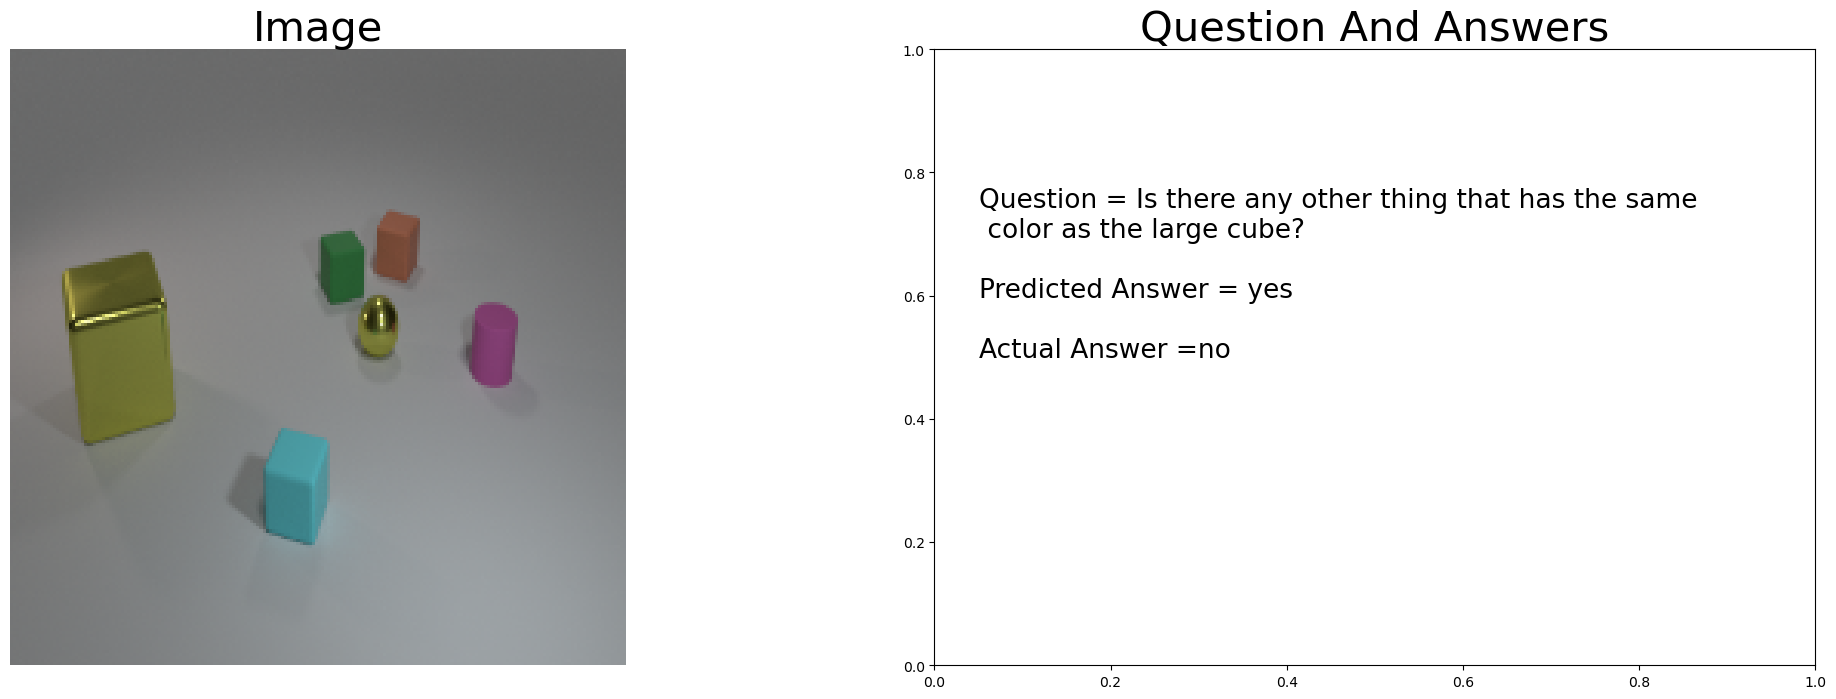

In [32]:
# print("Predictions Are as follows = ")

# for i in range(1):
#     index=1
#     fig,axis=plt.subplots(1,2,figsize=(25, 8))
#     im=cv2.imread(train_dataframe.iloc[index]['Path'])  #--
#     im=cv2.resize(im,(200,200))
#     q=train_dataframe.iloc[index]['Question']  #--
#     q=encoder.encode(q)
#     paddings = [[0, 50-tf.shape(q)[0]]]
#     q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
#     q=np.array(q)
#     print(im.shape)
#     print(q.shape)
#     ans=model.predict([[im],[q]])
#     question=""
#     flag=0
#     for i,j in enumerate(train_dataframe.iloc[index]['Question']):   #--
#         if (flag==1) and (j==' '):
#             question+='\n'
#             flag=0
#         question+=j
#         if (i%40==0)and (i!=0):
#             flag=1
#     axis[0].imshow(im)
#     axis[0].axis('off')
#     axis[0].set_title('Image', fontsize=30)
#     axis[1].text(0.05,0.5,
#              "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
#              transform=plt.gca().transAxes,fontsize=19)
#     axis[1].axis('on')
#     axis[1].set_title('Question And Answers', fontsize=30)
print("Predictions Are as follows = ")

for i in range(1):

    index=1

    fig,axis=plt.subplots(1,2,figsize=(25, 8))

    im=cv2.imread(train_dataframe.iloc[index]['Path'])  #--

    im=cv2.resize(im,(200,200))

    q=train_dataframe.iloc[index]['Question']  #--

    q=encoder.encode(q)

    paddings = [[0, 50-len(q)]]

    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)

    q=np.array(q)

    # Expand dimensions to match the model's expectations
    im_expanded = np.expand_dims(im, axis=0)
    q_expanded = np.expand_dims(q, axis=0)

    ans=model.predict([im_expanded, q_expanded])

    question=""

    flag=0

    for i,j in enumerate(train_dataframe.iloc[index]['Question']):   #--

        if (flag==1) and (j==' '):

            question+='\n'

            flag=0

        question+=j

        if (i%40==0)and (i!=0):

            flag=1

    axis[0].imshow(im)

    axis[0].axis('off')

    axis[0].set_title('Image', fontsize=30)

    axis[1].text(0.05,0.5,

             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),

             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)


### Random Testing

In [35]:
import random

# Define the number of random samples you want to test
num_samples_to_test = 5  # Adjust this number as needed

# Create a list to store the randomly selected indices
random_indices = random.sample(range(len(val_dataframe)), num_samples_to_test)

# Iterate over the randomly selected indices and retrieve images and answers
for index in random_indices:
    # Retrieve image path, question, and actual answer
    image_path = val_dataframe.iloc[index]['Path']
    question = val_dataframe.iloc[index]['Question']
    actual_answer = val_dataframe.iloc[index]['Answer']
    
    # Load and preprocess the image
    im = cv2.imread(image_path)
    im = cv2.resize(im, (200, 200))
    
    # Encode the question
    q = encoder.encode(question)
    paddings = [[0, 50 - len(q)]]
    q = tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q = np.array(q)
    
    # Expand dimensions to match the model's expectations
    im_expanded = np.expand_dims(im, axis=0)
    q_expanded = np.expand_dims(q, axis=0)
    
    # Predict the answer using the model
    predicted_answer = model.predict([im_expanded, q_expanded])
    
    # Decode the predicted answer
    decoded_answer = encoder.decode([np.argmax(predicted_answer)])
    
    # Print information about the test case
    print("Image Path:", image_path)
    print("Question:", question)
    print("Actual Answer:", actual_answer)
    print("Predicted Answer:", decoded_answer)
    print("\n")


1/1 [==============================] - 0s 36ms/step
Image Path: /home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/images/val/CLEVR_val_000494.png
Question: What number of other things are there of the same material as the cyan ball
Actual Answer: 3
Predicted Answer: 0


1/1 [==============================] - 0s 31ms/step
Image Path: /home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/images/val/CLEVR_val_000227.png
Question: Is the size of the matte block behind the red rubber cylinder the same as the green shiny thing?
Actual Answer: yes
Predicted Answer: yes


1/1 [==============================] - 0s 32ms/step
Image Path: /home/nadiera/Job_RecSys/Job_recommendation_engine/CLEVR_v1.0/images/val/CLEVR_val_000382.png
Question: There is a yellow thing; is it the same shape as the matte object behind the tiny yellow matte cube?
Actual Answer: no
Predicted Answer: blue


1/1 [==============================] - 0s 31ms/step
Image Path: /home/nadiera/Job_RecSys/Job_reco

1/1 [==============================] - 0s 33ms/step
Question: What shape is the object behind the block that is behind the large blue cube to the left of the cyan thing?
Actual Answer: sphere
Predicted Answer: blue


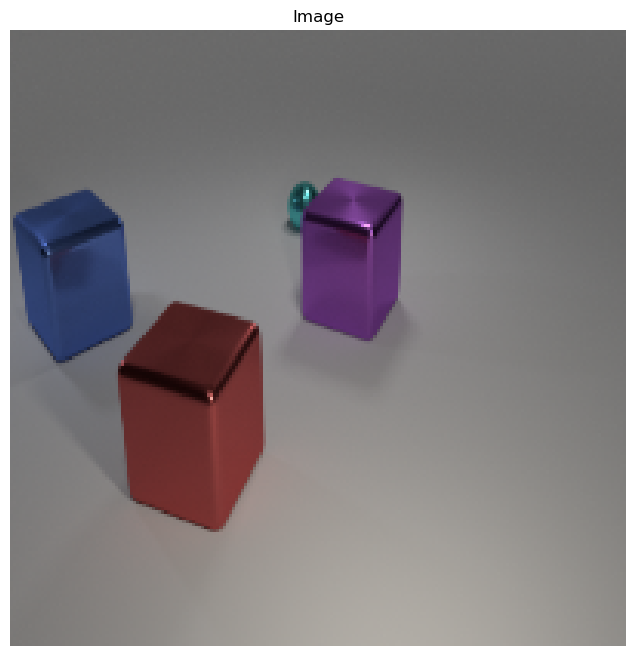



1/1 [==============================] - 0s 35ms/step
Question: There is a yellow object that is right of the large brown cube; is its shape the same as the purple object?
Actual Answer: no
Predicted Answer: blue


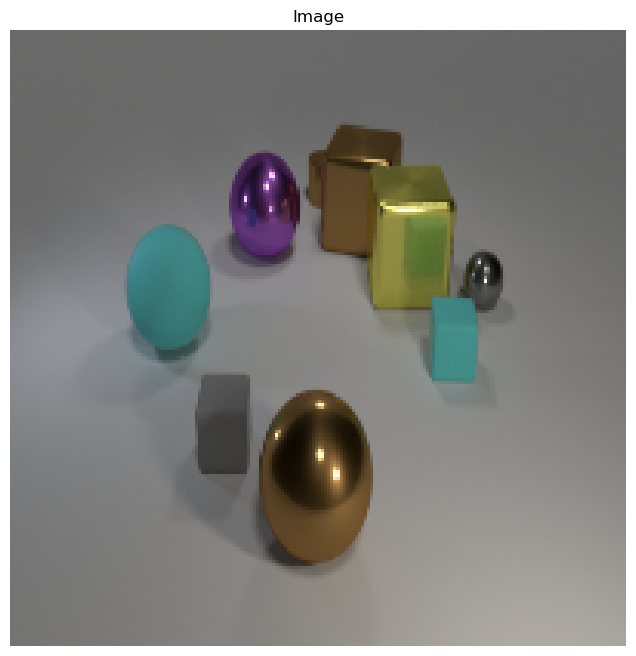



1/1 [==============================] - 0s 34ms/step
Question: What number of small cyan objects have the same material as the green thing?
Actual Answer: 1
Predicted Answer: 0


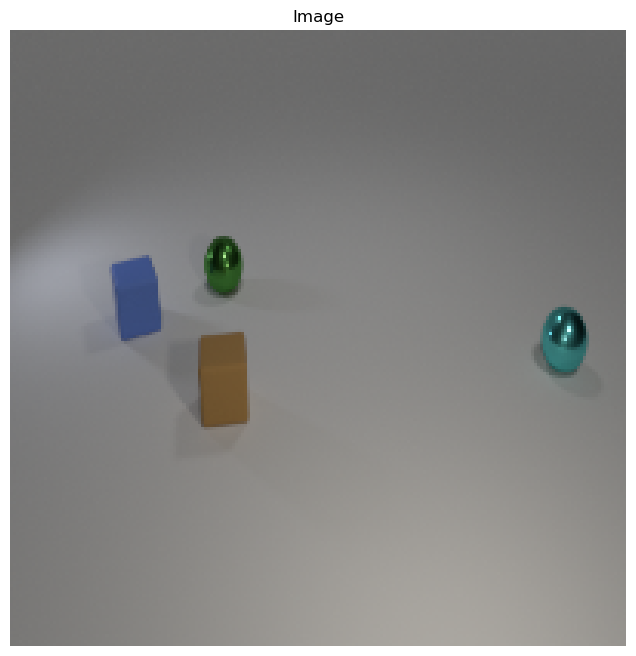



1/1 [==============================] - 0s 33ms/step
Question: Do the big brown shiny thing and the gray rubber object have the same shape?
Actual Answer: yes
Predicted Answer: yes


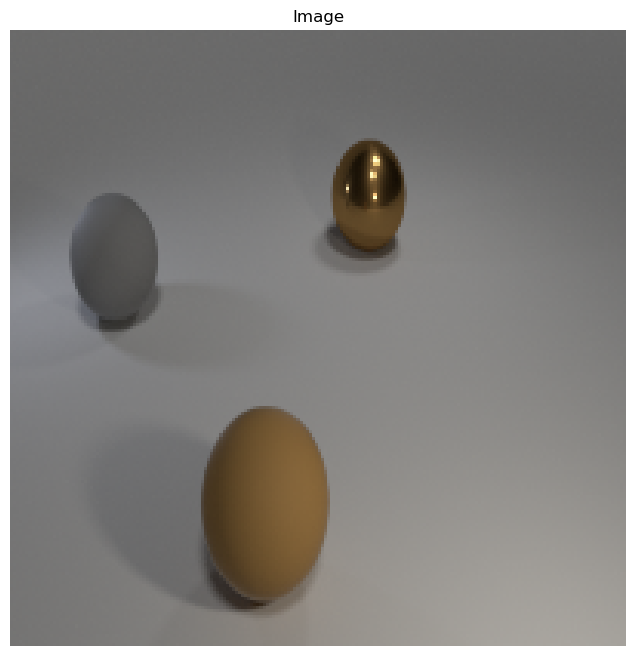



1/1 [==============================] - 0s 33ms/step
Question: The other tiny thing that is made of the same material as the small yellow object is what color?
Actual Answer: blue
Predicted Answer: blue


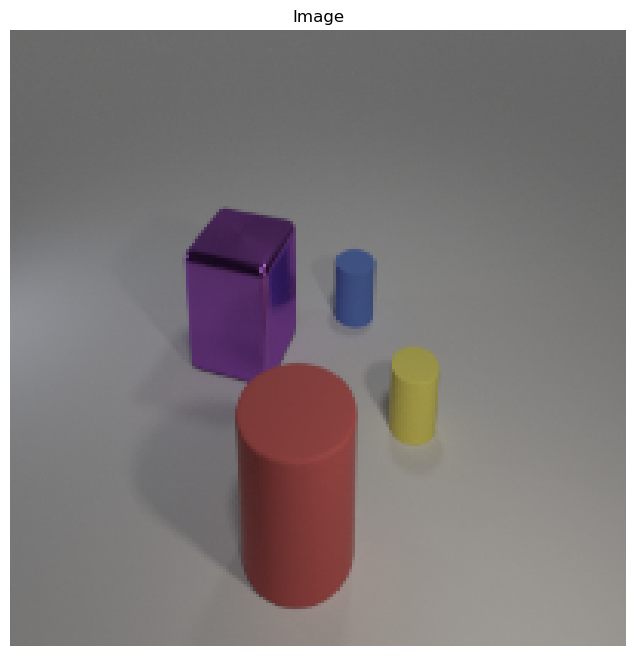



1/1 [==============================] - 0s 34ms/step
Question: What number of objects are tiny red shiny cylinders or rubber things?
Actual Answer: 3
Predicted Answer: 0


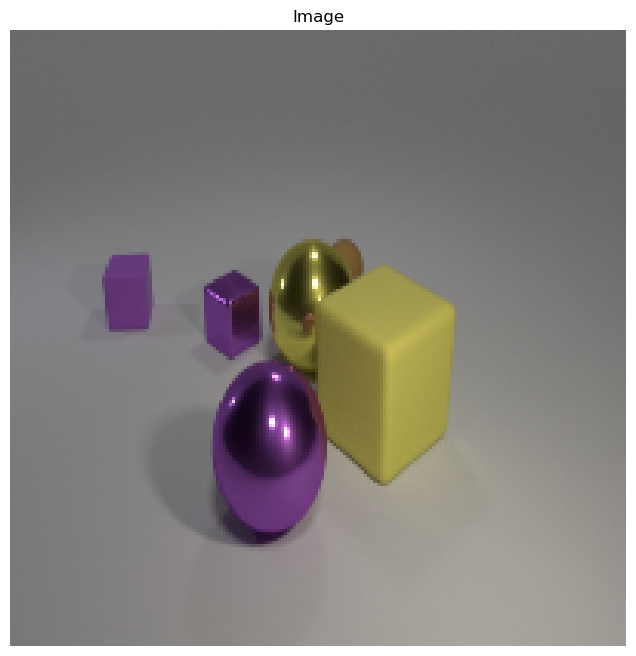



1/1 [==============================] - 0s 32ms/step
Question: Is the number of tiny metallic things in front of the rubber object less than the number of blue objects?
Actual Answer: yes
Predicted Answer: yes


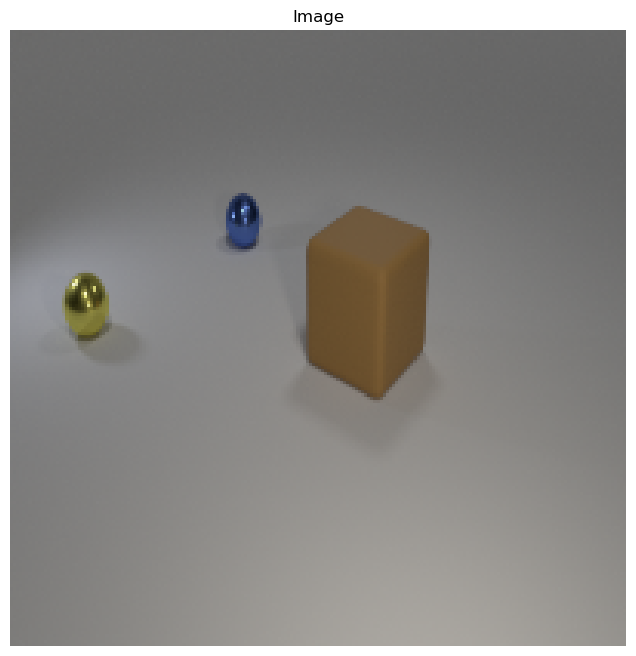



1/1 [==============================] - 0s 32ms/step
Question: Are there fewer large purple blocks that are to the left of the large object than small gray metal objects?
Actual Answer: yes
Predicted Answer: yes


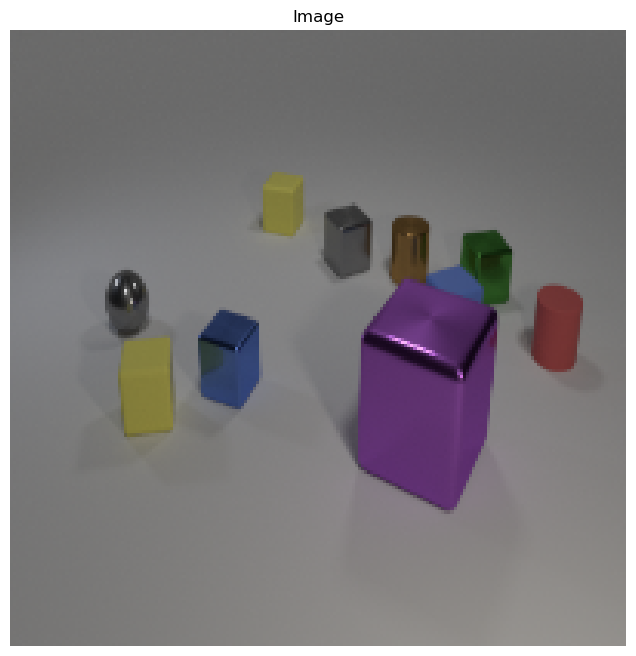



1/1 [==============================] - 0s 34ms/step
Question: Is the material of the small ball that is behind the green rubber thing the same as the large yellow cylinder?
Actual Answer: no
Predicted Answer: yes


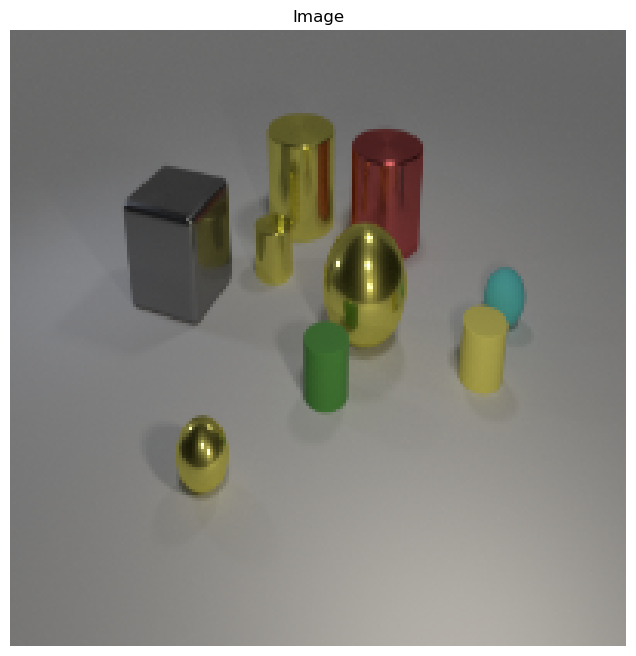



1/1 [==============================] - 0s 32ms/step
Question: Does the cyan object that is to the right of the big red ball have the same shape as the large thing that is on the right side of the green metal cube?
Actual Answer: no
Predicted Answer: yes


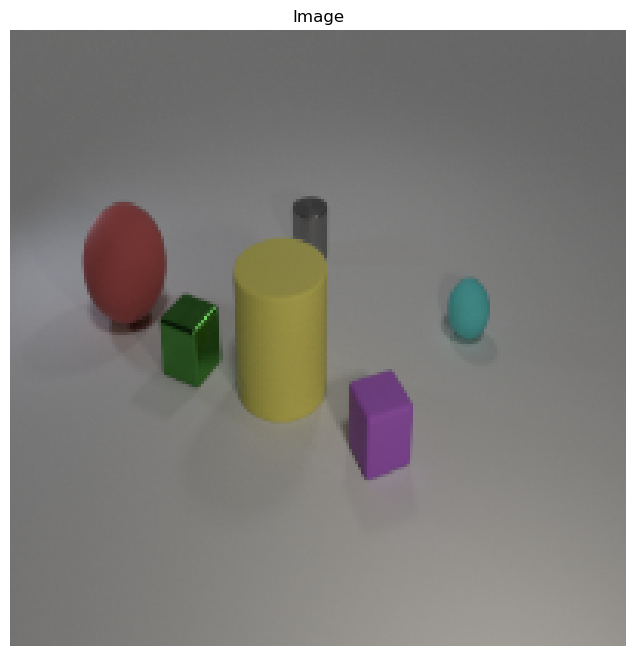

In [40]:
import random
import matplotlib.pyplot as plt
import cv2

# Define the number of random samples you want to test
num_samples_to_test = 10 # Adjust this number as needed

# Create a list to store the randomly selected indices
random_indices = random.sample(range(len(val_dataframe)), num_samples_to_test)

# Iterate over the randomly selected indices and retrieve images and answers
for index in random_indices:
    # Retrieve image path, question, and actual answer
    image_path = val_dataframe.iloc[index]['Path']
    question = val_dataframe.iloc[index]['Question']
    actual_answer = val_dataframe.iloc[index]['Answer']
    
    # Load and preprocess the image
    im = cv2.imread(image_path)
    im = cv2.resize(im, (200, 200))
    
    # Encode the question
    q = encoder.encode(question)
    paddings = [[0, 50 - len(q)]]
    q = tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q = np.array(q)
    
    # Expand dimensions to match the model's expectations
    im_expanded = np.expand_dims(im, axis=0)
    q_expanded = np.expand_dims(q, axis=0)
    
    # Predict the answer using the model
    predicted_answer = model.predict([im_expanded, q_expanded])
    
    # Decode the predicted answer
    decoded_answer = encoder.decode([np.argmax(predicted_answer)])
    
    # Visualize the image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Image')
    
    # Print information about the test case
    print("Question:", question)
    print("Actual Answer:", actual_answer)
    print("Predicted Answer:", decoded_answer)
    plt.show()
    print("\n")


In [41]:
print("Evaluation Metrics")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
history.history
hist.tail()

Evaluation Metrics


loss  sparse_categorical_accuracy  val_loss  \
0  3.115020                        0.204  4.946785   
1  1.818245                        0.448  5.886272   
2  0.919572                        0.740  4.828624   
3  0.404330                        0.866  4.210152   
4  0.307032                        0.906  4.048597   

   val_sparse_categorical_accuracy        lr  epoch  
0                            0.072  0.001000      0  
1                            0.072  0.001000      1  
2                            0.228  0.000905      2  
3                            0.222  0.000819      3  
4                            0.246  0.000741      4